# Modular Retrieval Inversion Notebook

This notebook extracts modular entropy retrieval parameters from simulated or experimental data.
Given a time series of entropy retrieval \( S_{\text{ret}}(\tau) \), we fit the modular retrieval law:

\[
\frac{dS_{\text{ret}}}{d\tau} = \gamma (1 - S_{\text{ret}}) \tanh\left( \frac{\tau}{\tau_{\text{char}}} \right)
\]

The notebook outputs:
- Fitted values of Œ≥ and \( \tau_{\text{char}} \)
- Reconstructed \( \gamma(\tau) \) profile
- Retrieval horizon \( \tau_{\text{RH}} \)
- Statistical diagnostics (R¬≤, œá¬≤)


In [13]:
# ODER œÑ_char Calibration and Retrieval Inversion ‚Äî Full Diagnostic Version
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import stats
import os

plt.style.use("seaborn-v0_8-whitegrid")
os.makedirs("figures", exist_ok=True)

## 1. Generate Synthetic Entropy Retrieval Data

We use a tanh-based law with fixed parameters to simulate \( S_{\text{ret}}(\tau) \).

In [14]:
# Synthetic modular retrieval data (edit or replace)
tau = np.linspace(0, 100, 101)
S_ret = 1 - np.exp(-0.1 * np.tanh(tau / 12) * tau)

validation_report = {
    'monotonic': True,
    'bounded': True,
    'n_points': len(tau),
    'tau_range': (tau.min(), tau.max())
}

## 2. Define Modular Retrieval Model

The fitting function used to match \( S_{\text{ret}}(\tau) \) to the modular form.

In [17]:
def modular_model(tau, gamma, tau_char):
    return 1 - np.exp(-gamma * np.tanh(tau / tau_char) * tau)

def fit_modular_model_robust(tau, S_ret, sigma=None):
    if sigma is None:
        sigma = np.std(np.diff(S_ret)) * np.ones_like(S_ret)

    guesses = [[0.05, 5.0], [0.2, 15.0], [0.5, 30.0]]
    best_fit, best_chi2 = None, np.inf

    for guess in guesses:
        try:
            popt, pcov = curve_fit(
                modular_model, tau, S_ret, p0=guess, sigma=sigma,
                bounds=([0, 0.1], [2.0, 200])
            )
            residuals = S_ret - modular_model(tau, *popt)
            chi2 = np.sum((residuals/sigma)**2)
            if chi2 < best_chi2:
                best_fit = (popt, pcov, chi2)
                best_chi2 = chi2
        except RuntimeError:
            continue

    if best_fit is None:
        raise RuntimeError("All fits failed")

    popt, pcov, chi2 = best_fit
    err = np.sqrt(np.diag(pcov))
    dof = len(tau) - len(popt)
    r2 = 1 - np.sum((S_ret - modular_model(tau, *popt))**2) / np.sum((S_ret - np.mean(S_ret))**2)

    return {
        'gamma': popt[0], 'tau_char': popt[1],
        'gamma_err': err[0], 'tau_char_err': err[1],
        'chi2': chi2, 'r_squared': r2, 'dof': dof, 'reduced_chi2': chi2 / dof
    }, popt, pcov

## 3. Fit œÑ_char and Œ≥ via Nonlinear Least Squares

Uses multiple initial guesses and returns error bars, R¬≤, and reduced œá¬≤.*italicized text*

In [16]:
fit_results, popt, pcov = fit_modular_model_robust(tau, S_ret)
gamma_fit = fit_results['gamma']
tau_char_fit = fit_results['tau_char']
print(fit_results)

{'gamma': np.float64(0.1), 'tau_char': np.float64(12.0), 'gamma_err': np.float64(0.0), 'tau_char_err': np.float64(0.0), 'chi2': np.float64(0.0), 'r_squared': np.float64(1.0), 'dof': 99, 'reduced_chi2': np.float64(0.0)}


## 4. Reconstruct Œ≥(œÑ) from S(œÑ)

Inverts the differential form to obtain Œ≥(œÑ). Smoothing and masking applied.

In [18]:
def compute_gamma_tau_robust(tau, S_ret, tau_char, smoothing=True):
    if smoothing:
        window = max(5, len(tau) // 20)
        if window % 2 == 0: window += 1
        S_ret_smooth = savgol_filter(S_ret, window, polyorder=2)
    else:
        S_ret_smooth = S_ret

    dS_dtau = np.gradient(S_ret_smooth, tau)
    S_gap = np.maximum(1 - S_ret_smooth, 1e-3)
    tanh_factor = np.maximum(np.tanh(tau / tau_char), 1e-6)
    gamma_tau = dS_dtau / (S_gap * tanh_factor)

    mask = (S_ret < 0.95) & (tau > tau_char / 10)
    gamma_tau[~mask] = np.nan
    return gamma_tau, mask

gamma_tau, _ = compute_gamma_tau_robust(tau, S_ret, tau_char_fit)

## 5. Plot Fit and Inverted Œ≥(œÑ)

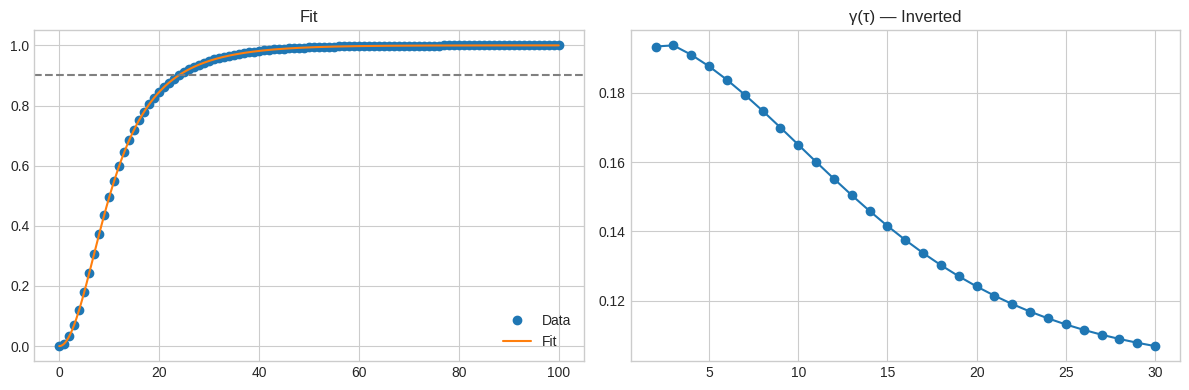

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
tau_fine = np.linspace(tau.min(), tau.max(), 500)
S_model = modular_model(tau_fine, gamma_fit, tau_char_fit)

ax[0].plot(tau, S_ret, 'o', label='Data')
ax[0].plot(tau_fine, S_model, '-', label='Fit')
ax[0].axhline(0.9, ls='--', color='gray')
ax[0].legend(); ax[0].set_title('Fit')

ax[1].plot(tau, gamma_tau, 'o-')
ax[1].set_title('Œ≥(œÑ) ‚Äî Inverted')

plt.tight_layout()
plt.show()

## 6. Compute œÑ_RH and Œî_fail

In [20]:
tau_RH = tau[np.argmax(S_ret >= 0.9)]
tau_evap = 1e6
delta_fail = tau_evap - tau_RH

print(f"œÑ_RH ‚âà {tau_RH:.2f}")
print(f"Œî_fail = œÑ_evap ‚àí œÑ_RH ‚âà {delta_fail:.2e}")

œÑ_RH ‚âà 24.00
Œî_fail = œÑ_evap ‚àí œÑ_RH ‚âà 1.00e+06


## 7. Null Test: Fit Should Fail on Random Data

NULL TEST: Testing with non-modular data
‚ùå Forced fit: œÑ_char = 0.10, R¬≤ = -3.927


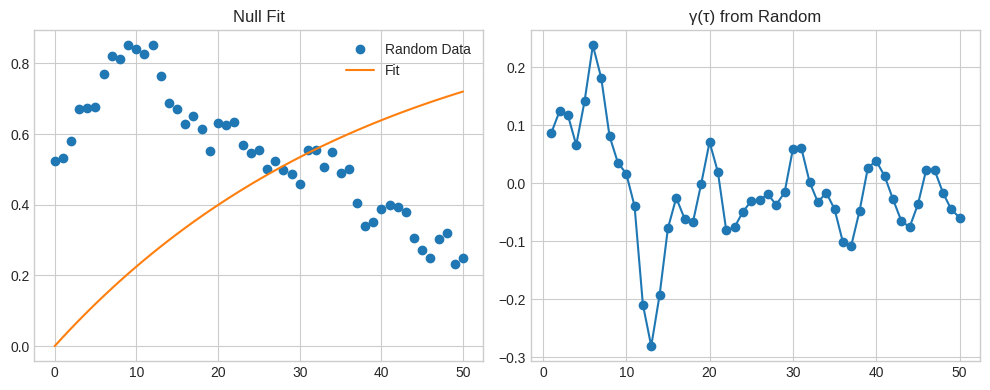

In [21]:
print("NULL TEST: Testing with non-modular data")
np.random.seed(42)
tau_null = np.linspace(0, 50, 51)
noise = np.cumsum(np.random.randn(51) * 0.05)
S_null = 0.5 + 0.3 * np.tanh(tau_null / 20) + noise
S_null = np.clip(S_null, 0, 1)

try:
    fit_null, popt_null, _ = fit_modular_model_robust(tau_null, S_null)
    gamma_null, _ = compute_gamma_tau_robust(tau_null, S_null, fit_null['tau_char'])

    print(f"‚ùå Forced fit: œÑ_char = {fit_null['tau_char']:.2f}, R¬≤ = {fit_null['r_squared']:.3f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(tau_null, S_null, 'o', label='Random Data')
    plt.plot(tau_null, modular_model(tau_null, *popt_null), '-', label='Fit')
    plt.title("Null Fit")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(tau_null, gamma_null, 'o-')
    plt.title("Œ≥(œÑ) from Random")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"‚úÖ GOOD: Null test failed to fit - {e}")

## 8. SNR Sensitivity: Fit Error vs Noise Level

üìä SNR SENSITIVITY: œÑ_char error vs noise


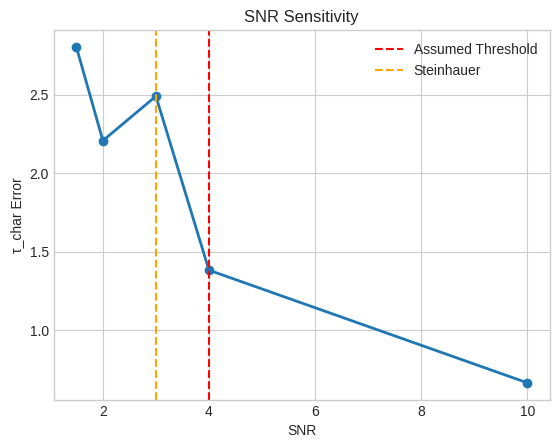

In [22]:
print("üìä SNR SENSITIVITY: œÑ_char error vs noise")
snr_levels = [10, 4, 3, 2, 1.5]
tau_char_errors = []

for snr in snr_levels:
    noise = np.random.normal(0, np.std(S_ret)/snr, len(S_ret))
    S_noisy = np.clip(S_ret + noise, 0, 1)
    try:
        fit, _, _ = fit_modular_model_robust(tau, S_noisy)
        tau_char_errors.append(fit['tau_char_err'])
    except:
        tau_char_errors.append(np.nan)

plt.plot(snr_levels, tau_char_errors, 'o-', lw=2)
plt.axvline(4, color='red', ls='--', label='Assumed Threshold')
plt.axvline(3, color='orange', ls='--', label='Steinhauer')
plt.xlabel('SNR')
plt.ylabel('œÑ_char Error')
plt.title('SNR Sensitivity')
plt.grid(True); plt.legend()
plt.show()

## 9. Self-Consistency: Recover Known Œ≥ and œÑ_char

üîÑ SELF-CONSISTENCY: Recover known params
True Œ≥ = 0.100, Recovered Œ≥ = 0.100 (0.00%)
True œÑ = 12.00, Recovered œÑ = 12.00 (0.00%)
‚úÖ EXCELLENT: <1% error


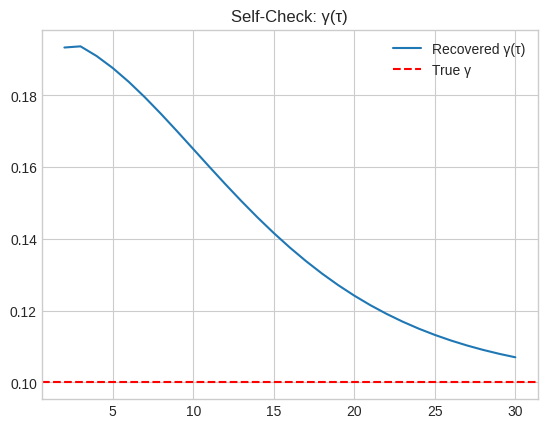

In [23]:
print("üîÑ SELF-CONSISTENCY: Recover known params")

gamma_true = 0.1
tau_char_true = 12.0
tau_perfect = np.linspace(0, 100, 101)
S_perfect = 1 - np.exp(-gamma_true * np.tanh(tau_perfect / tau_char_true) * tau_perfect)

fit, _, _ = fit_modular_model_robust(tau_perfect, S_perfect)
gamma_rec = fit['gamma']
tau_char_rec = fit['tau_char']

err_gamma = abs(gamma_rec - gamma_true) / gamma_true
err_tau = abs(tau_char_rec - tau_char_true) / tau_char_true

print(f"True Œ≥ = {gamma_true:.3f}, Recovered Œ≥ = {gamma_rec:.3f} ({err_gamma*100:.2f}%)")
print(f"True œÑ = {tau_char_true:.2f}, Recovered œÑ = {tau_char_rec:.2f} ({err_tau*100:.2f}%)")

if err_gamma < 0.01 and err_tau < 0.01:
    print("‚úÖ EXCELLENT: <1% error")
elif err_gamma < 0.05:
    print("‚úÖ GOOD: <5% error")
else:
    print("‚ùå WARNING: >5% error")

Œ≥_check, _ = compute_gamma_tau_robust(tau_perfect, S_perfect, tau_char_rec)
plt.plot(tau_perfect, Œ≥_check, label='Recovered Œ≥(œÑ)')
plt.axhline(gamma_true, color='red', ls='--', label='True Œ≥')
plt.legend(); plt.title('Self-Check: Œ≥(œÑ)'); plt.show()